In [1]:
import dask.array as da
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
zarr_ds = xr.open_zarr("~/shared-public/mind_the_chl_gap/IO.zarr")

In [3]:
zarr_sliced = zarr_ds.sel(lat=slice(35, -5), lon=slice(45,90))
zarr_sliced = zarr_sliced.sel(time=slice('2020-01-01', '2020-12-31'))

In [4]:
all_nan_CHL = np.isnan(zarr_sliced["CHL_cmes-level3"]).all(dim=["lon", "lat"]).compute()  # find sample indices where CHL is NaN
zarr_CHL = zarr_sliced.sel(time=(all_nan_CHL == False))  # select samples with CHL not NaN

In [5]:
zarr_CHL

<xarray.Dataset> Size: 958MB
Dimensions:                       (time: 366, lat: 149, lon: 181)
Coordinates:
  * lat                           (lat) float32 596B 32.0 31.75 ... -4.75 -5.0
  * lon                           (lon) float32 724B 45.0 45.25 ... 89.75 90.0
  * time                          (time) datetime64[ns] 3kB 2020-01-01 ... 20...
Data variables: (12/27)
    CHL                           (time, lat, lon) float32 39MB dask.array<chunksize=(73, 149, 181), meta=np.ndarray>
    CHL_cmes-cloud                (time, lat, lon) uint8 10MB dask.array<chunksize=(73, 149, 181), meta=np.ndarray>
    CHL_cmes-gapfree              (time, lat, lon) float32 39MB dask.array<chunksize=(73, 149, 181), meta=np.ndarray>
    CHL_cmes-land                 (lat, lon) uint8 27kB dask.array<chunksize=(149, 181), meta=np.ndarray>
    CHL_cmes-level3               (time, lat, lon) float32 39MB dask.array<chunksize=(73, 149, 181), meta=np.ndarray>
    CHL_cmes_flags-gapfree        (time, lat, lon) float32 39MB dask.array<chunksize=(73, 149, 181), meta=np.ndarray>
    ...                            ...
    ug_curr                       (time, lat, lon) float32 39MB dask.array<chunksize=(73, 149, 181), meta=np.ndarray>
    v_curr                        (time, lat, lon) float32 39MB dask.array<chunksize=(73, 149, 181), meta=np.ndarray>
    v_wind                        (time, lat, lon) float32 39MB dask.array<chunksize=(73, 149, 181), meta=np.ndarray>
    vg_curr                       (time, lat, lon) float32 39MB dask.array<chunksize=(73, 149, 181), meta=np.ndarray>
    wind_dir                      (time, lat, lon) float32 39MB dask.array<chunksize=(73, 149, 181), meta=np.ndarray>
    wind_speed                    (time, lat, lon) float32 39MB dask.array<chunksize=(73, 149, 181), meta=np.ndarray>
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L3_MY_009_103
    ...                              ...
    time_coverage_end:               2024-04-18T02:58:23Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-04-16T21:12:05Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l3-mult...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0

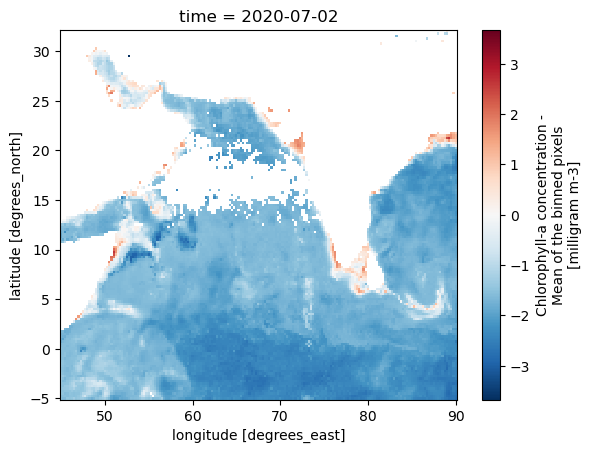

In [6]:
np.log(zarr_CHL.sel(time='2020-07-02').CHL).plot(y='lat', x='lon');

In [7]:
def log_label(data, label):
    data_logged = data.copy()
    data_logged[label] = np.log(data[label]).copy()
    return data_logged

In [8]:
def preprocess_data(data, features, label):
    data_logged = log_label(data, label)

    sel_data_list = []
    for var in (features + [label]):
        sel_var_data = data_logged[var]
        sel_var_data = da.where(da.isnan(sel_var_data), 0.0, sel_var_data)
        sel_data_list.append(sel_var_data)

    sel_data_da =  da.array(sel_data_list)

    return sel_data_da

In [9]:
def time_series_split(data, split_ratio):
    X = data[:-1] # selects features
    y = data[-1] # selects labels
    
    X = np.moveaxis(X, 0, -1)

    total_length = X.shape[0]
    
    train_end = int(total_length * split_ratio[0])
    val_end = int(total_length * (split_ratio[0] + split_ratio[1]))

    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end: val_end], y[train_end: val_end]
    X_test, y_test = X[val_end:], y[val_end:]

    return (X_train, y_train,
            X_val, y_val,
            X_test, y_test)

In [10]:
# Curr Features: Sea Surface Temp (K), Sea Salinity Concentration (m**-3 or PSL). [Excluding Topography/Bathymetry (m)]
features = ['sst', 'so'] 
label = 'CHL_cmes-level3'  # chlorophyll-a concentration (mg/m**3) [Not taking uncertainty into consideration for now]
model_data = preprocess_data(zarr_CHL, features, label)

split_ratio = [.7, .2, .1]
X_train, y_train, X_val, y_val, X_test, y_test = time_series_split(model_data, split_ratio)

In [11]:
X_train

dask.array<getitem, shape=(256, 149, 181, 2), dtype=float32, chunksize=(73, 149, 181, 1), chunktype=numpy.ndarray>

In [93]:
# Saving as a numpy array loses chunking but only uses one file for multiple variables
np.savez('npz_test.npz',
         X_train=np.array(X_train),
         X_test=np.array(X_test))

In [95]:
data = np.load('npz_test.npz')

In [99]:
da.from_array(data['X_train'])

dask.array<array, shape=(256, 149, 181, 2), dtype=float32, chunksize=(256, 149, 181, 2), chunktype=numpy.ndarray>

In [97]:
da.from_array(data['X_test'])

dask.array<array, shape=(37, 149, 181, 2), dtype=float32, chunksize=(37, 149, 181, 2), chunktype=numpy.ndarray>

In [52]:
# Npy stack retains chunking
da.to_npy_stack('test', X_train)

In [74]:
meh = da.from_npy_stack('test')
meh

dask.array<from-npy-stack, shape=(256, 149, 181, 2), dtype=float32, chunksize=(73, 149, 181, 2), chunktype=numpy.ndarray>

In [68]:
#hdf5 gave me errors
#X_train.to_hdf5('myfile.hdf5', '/X_train') 
#X_train2 = dd.read_hdf('myfile.hdf5', '/X_train')

In [19]:
import zarr
X_train_rechunk = X_train.rechunk((64, 149, 181, 1))

In [26]:
X_train

dask.array<getitem, shape=(256, 149, 181, 2), dtype=float32, chunksize=(73, 149, 181, 1), chunktype=numpy.ndarray>

In [70]:
# Zarr is much smaller file size, but had to rechunk because chunk sizes weren't equal
import zarr
X_train_rechunk = X_train.rechunk()
zstore = zarr.DirectoryStore('example.zarr')
X_train_rechunk.to_zarr(zstore)

In [73]:
meh = da.from_zarr('example.zarr')
meh

dask.array<from-zarr, shape=(256, 149, 181, 2), dtype=float32, chunksize=(256, 149, 181, 2), chunktype=numpy.ndarray>

In [103]:
pip install keras -q

Note: you may need to restart the kernel to use updated packages.


In [107]:
pip install tensorflow -q

Note: you may need to restart the kernel to use updated packages.


In [110]:
from keras.layers import ConvLSTM2D, BatchNormalization, Conv2D, Dropout
from keras.models import Sequential

In [111]:
def create_model_CNN(input_shape=(149, 181, 2)):
    model = Sequential()
    
    model.add(Conv2D(filters=64, 
                     kernel_size=(3, 3), 
                     input_shape=input_shape, 
                     padding='same',
                     activation='relu'
                     ))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     padding='same',
                     activation='relu'
                     ))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=1, 
                     kernel_size=(3, 3), 
                     padding='same', 
                     activation='linear'
                     ))
    
    return model

model = create_model_CNN()
model.summary()

/srv/conda/envs/notebook/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 149, 181, 64)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 149, 181, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 149, 181, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 149, 181, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 149, 181, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 149, 181, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 149, 181, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,353 (79.50 KB)

 Trainable params: 20,161 (78.75 KB)

 Non-trainable params: 192 (768.00 B)